In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time

In [2]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)

Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [3]:
cd C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/

C:\Users\alexc\OneDrive - University Of Cambridge\Documents\PhD Project\Projects


In [394]:
data_f.close()

In [4]:
data_f = df.current()
fname = data_f.filename

No current data file, attempting to create...
C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/2018-09-03_melting NPs on monolayer hBN.h5
opening file:  C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/2018-09-03_melting NPs on monolayer hBN.h5


In [6]:
filelist = data_f['OceanOpticsSpectrometer']
camlist = data_f['LumeneraCamera']

In [5]:

start_time = datetime.datetime.strptime('2018-09-03T15:09:11.247000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time = datetime.datetime.strptime('2018-09-03T15:37:24.336000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [9]:
#Sort by timestamp

ref = filelist[filelist.keys()[0]].attrs['reference']
back = filelist[filelist.keys()[0]].attrs['background']
wavelengths = filelist[filelist.keys()[0]].attrs['wavelengths']
wavelength_start = 505; wavelength_end = 1000;
data_start = (np.abs(wavelengths - wavelength_start)).argmin()
data_end = (np.abs(wavelengths - wavelength_end)).argmin()


wavelengths = wavelengths[data_start:data_end]

all_data_w_time = []

for data_set in filelist.values():
    
    t = datetime.datetime.strptime(
                        data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")
    
    data = (data_set.value - back)/(ref-back)
    data = data[data_start:data_end]
    
    if t >= start_time and t <= finish_time:

        s = (t-datetime.datetime(1970,1,1)).total_seconds()

        data_w_time = np.append(data, s)
        all_data_w_time.append(data_w_time)
    
    
all_data_w_time_sorted = sorted(all_data_w_time,key=lambda x: x[-1])
all_data_w_time_sorted = np.delete(all_data_w_time_sorted, -1,1)


#Filter the data to help define peaks
all_data_filtered = []
for i in range(0, len(all_data_w_time_sorted)):
    filt_data = sig.savgol_filter(all_data_w_time_sorted[i],23,3)
    all_data_filtered.append(filt_data)
    

C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in divide


In [33]:
#Decides how the normalisation is done
normalise_start = 650; #Wavelength to normalised from
normalise_start = (np.abs(wavelengths - normalise_start)).argmin()

del_selection = np.linspace(0,normalise_start, normalise_start+1, dtype = int)
norm_mat = np.delete(all_data_w_time_sorted, del_selection, 1)
norm_mat_filtered = np.delete(all_data_filtered, del_selection, 1)

inf_norm = np.linalg.norm(norm_mat, axis=1, ord = np.inf)
all_data_w_time_sorted_norm = all_data_w_time_sorted/inf_norm[:,None]
inf_norm_filtered = np.linalg.norm(norm_mat_filtered, axis= 1, ord = np.inf)
all_data_norm_filtered = all_data_filtered/inf_norm_filtered[:,None]


(0, 14.799999999999999)

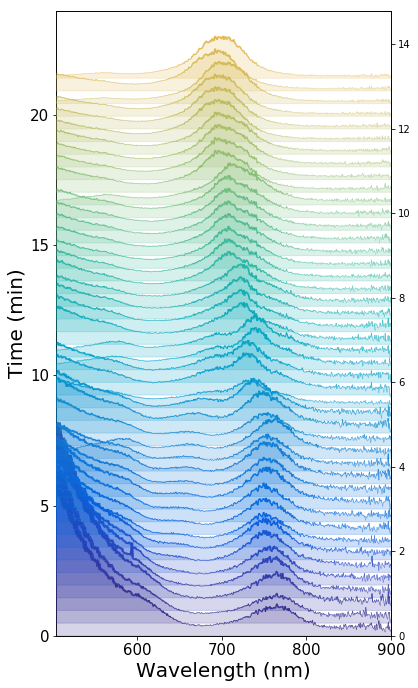

In [126]:
mega_fact = 0.3
all_data_w_time_sorted_offset_n = Alex_plot.offset_spectra(all_data_w_time_sorted_norm, mega_fact)

fig1 = plt.figure(1, figsize = (6,0.25*len(all_data_w_time_sorted_offset_n)))
ax1 = fig1.add_subplot(111)
ax1b = ax1.twinx()


colours = parula_map(np.linspace(0,0.8,len(all_data_w_time_sorted_offset_n)))
for i in range(0, len(all_data_w_time_sorted_offset_n)-1):
    lwidths = (all_data_w_time_sorted_offset_n[i] - i*mega_fact)*2
    points = np.array([wavelengths, all_data_w_time_sorted_offset_n[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax1b.add_collection(lc_2)
    spec1 = np.array(all_data_w_time_sorted_offset_n[i], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
    spec2 = np.ones(len(wavelengths))*i*mega_fact
    ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
                alpha = 0.2, zorder = 3)


ax1.set_xlim(505, 900)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Time (min)", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0,24)
ax1b.set_ylim(0, len(all_data_w_time_sorted_offset_n)*mega_fact + 1)


In [127]:
fig1.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/NP4_offset.png")

(0, 14.799999999999999)

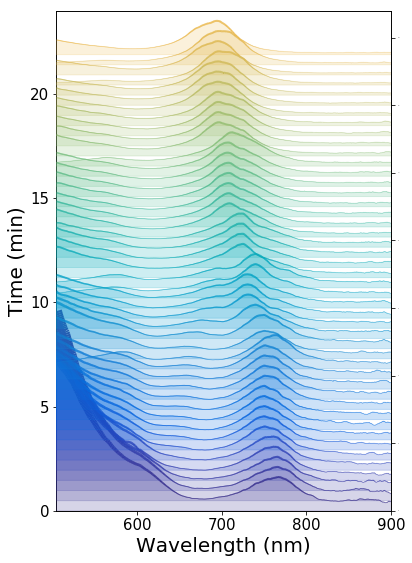

In [128]:
mega_fact = 0.3
all_data_norm_filtered_n = Alex_plot.offset_spectra(all_data_norm_filtered, mega_fact)

fig1 = plt.figure(1, figsize = (6,0.2*len(all_data_norm_filtered_n)))
ax1 = fig1.add_subplot(111)
ax1b=ax1.twinx()

colours = parula_map(np.linspace(0,0.8,len(all_data_norm_filtered_n)))
for i in range(0, len(all_data_norm_filtered_n)):
    lwidths = (all_data_norm_filtered_n[i] - i*mega_fact)*2
    points = np.array([wavelengths, all_data_norm_filtered_n[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax1b.add_collection(lc_2)
    spec1 = np.array(all_data_norm_filtered_n[i], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
    spec2 = np.ones(len(wavelengths))*i*mega_fact
    ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
                alpha = 0.2, zorder = 3)


ax1.set_ylim(0, 24)
#ax1b.set_ylabel('Spectrum No.', fontsize = 0)
ax1.set_xlim(505, 900)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Time (min)", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1b.tick_params(axis = 'y', labelsize = 0)
ax1b.set_ylim(0, len(all_data_norm_filtered)*mega_fact+1)

In [129]:
fig1.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/NP4_smoothed_offset.png")

(0, 24)

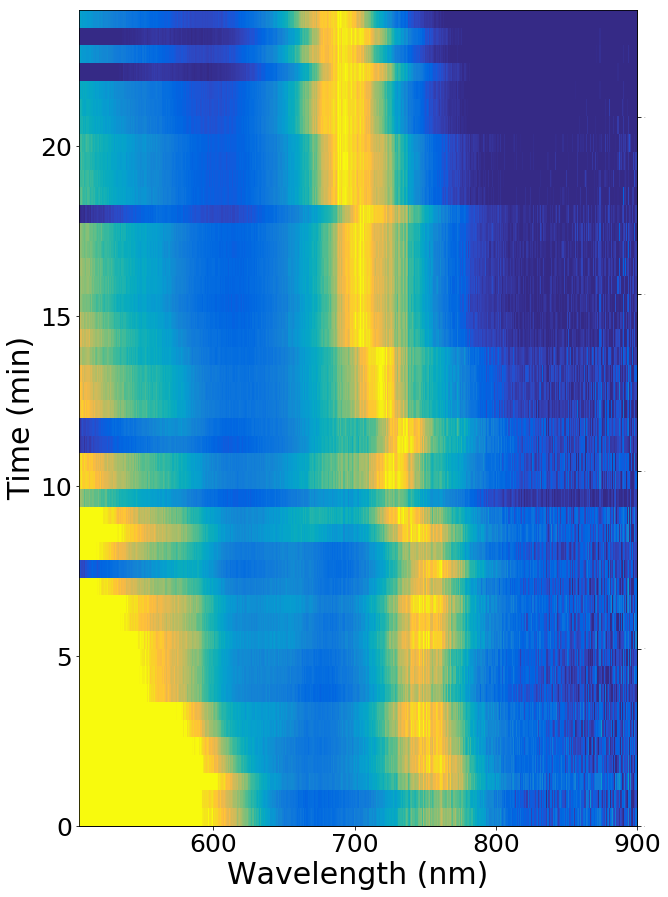

In [130]:
fig3=plt.figure(3, figsize = (10, 15))
ax3=fig3.add_subplot(111)

ax3b=ax3.twinx()
mapfig1 = ax3b.imshow(np.flip(all_data_w_time_sorted_norm, 0), 
                    extent=[wavelength_start, wavelength_end,
                    0, len(all_data_w_time_sorted_norm)], aspect = 'auto', 
                            cmap = parula_map, vmin = 0.1, clim=(0, 1), interpolation = 'none')

ax3.set_ylabel('Time (min)', Fontsize = 30)
ax3.set_xlim(505, 900)
ax3.set_xlabel('Wavelength (nm)', Fontsize = 30)
ax3.tick_params(axis='x', labelsize=25)
ax3.tick_params(axis='y', labelsize=25)
ax3b.tick_params(axis='y', labelsize=0)
ax3.set_ylim(0,24)

In [131]:
fig3.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/NP4_map.png")

(0, 24)

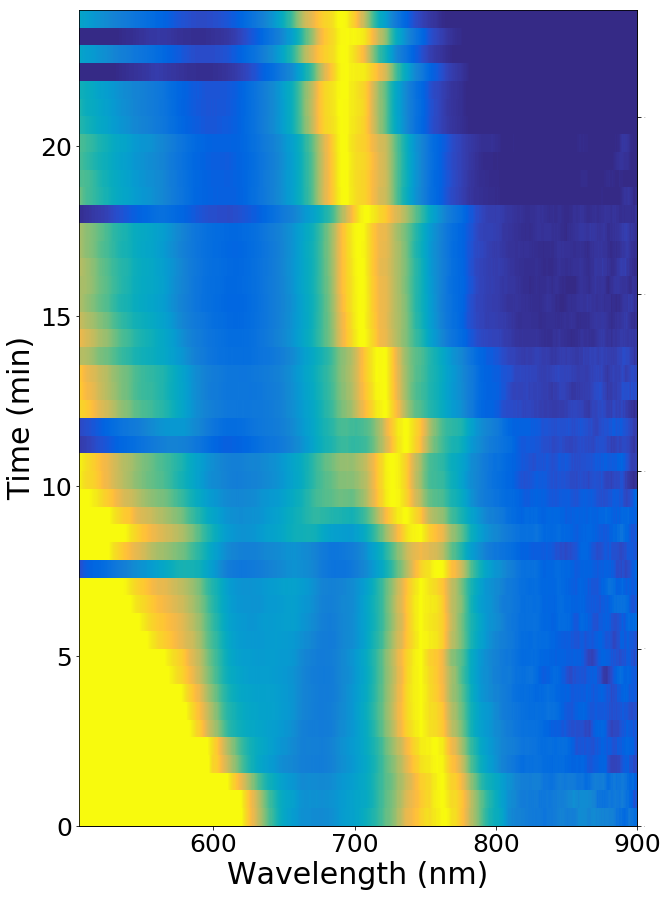

In [132]:
fig3=plt.figure(3, figsize = (10, 15))
ax3=fig3.add_subplot(111)


ax3b=ax3.twinx()
mapfig1 = ax3b.imshow(np.flip(all_data_norm_filtered, 0), 
                    extent=[wavelength_start, wavelength_end,
                    0, len(all_data_norm_filtered)], aspect = 'auto', 
                            cmap = parula_map, vmin = 0.1, clim=(0, 1), interpolation = 'none')


ax3.set_ylabel('Time (min)', Fontsize = 30)
ax3.set_xlim(505, 900)
ax3.set_xlabel('Wavelength (nm)', Fontsize = 30)
ax3.tick_params(axis='x', labelsize=25)
ax3.tick_params(axis='y', labelsize=25)
ax3b.tick_params(axis='y', labelsize=0)
ax3.set_ylim(0,24)

In [133]:
fig3.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Boron Nitride spacer/Embedded hBN on Au/2018_09_06 CVD_hBN_gas_phase_NPs_melting_80nm_sonicated/NP4_smoothed_map.png")